# Prophet을 사용한 시계열 예측
- 시간 단위 전력 사용량 예측
- Prophet 설치가 안되는 경우, 코랩에서 실행 권장 

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

# 데이터
- `PJM East` 2002-2018 동부지역 데이터
- Pennsylvania, Jersey, Maryland Power Pool

In [2]:
pjme = pd.read_csv('../power_forecasting/PJME_hourly.csv',
        index_col=[0], parse_dates=[0])

In [4]:
print(pjme.shape); pjme[:3]

(145366, 1)


PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0

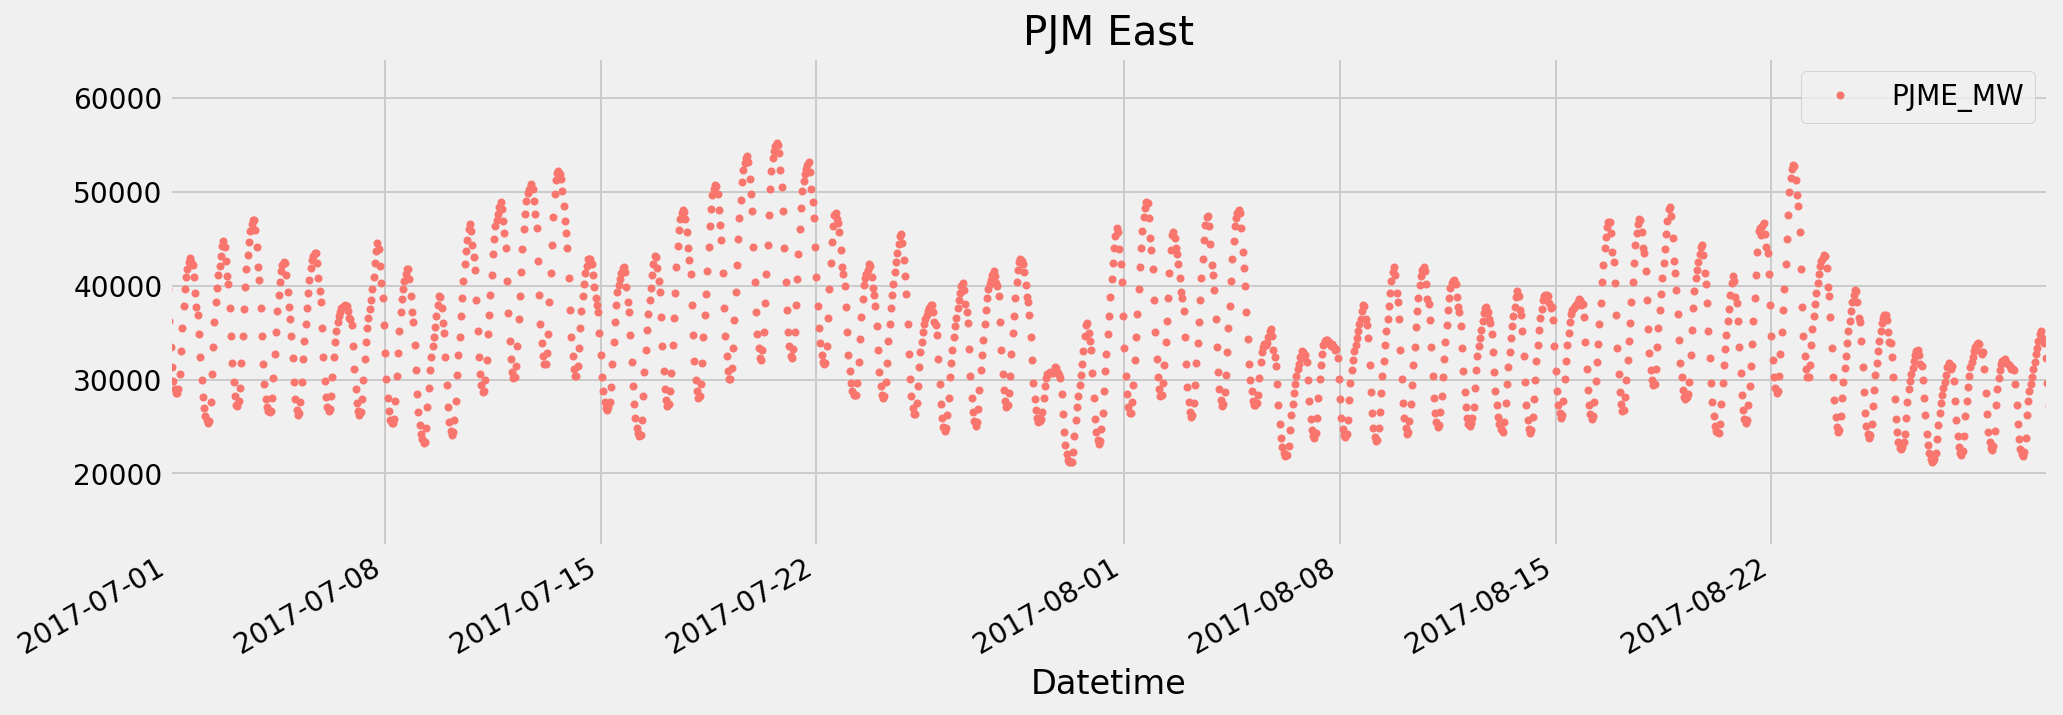

In [18]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
from datetime import datetime
# plt.xlim([datetime(2017, 7, 1), datetime(2017, 8, 31)])
plt.show()

# EDA

- day of week, hour, time of year

In [20]:
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [23]:
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)
features_and_target[:3]

hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2002-12-31 01:00:00     1          1        4     12  2002        365   
2002-12-31 02:00:00     2          1        4     12  2002        365   
2002-12-31 03:00:00     3          1        4     12  2002        365   

                     dayofmonth  weekofyear  PJME_MW  
Datetime                                              
2002-12-31 01:00:00          31           1  26498.0  
2002-12-31 02:00:00          31           1  25147.0  
2002-12-31 03:00:00          31           1  24574.0

In [24]:
features_and_target = features_and_target.sort_index()

In [30]:
features_and_target[:3]

hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2002-01-01 01:00:00     1          1        1      1  2002          1   
2002-01-01 02:00:00     2          1        1      1  2002          1   
2002-01-01 03:00:00     3          1        1      1  2002          1   

                     dayofmonth  weekofyear  PJME_MW  
Datetime                                              
2002-01-01 01:00:00           1           1  30393.0  
2002-01-01 02:00:00           1           1  29265.0  
2002-01-01 03:00:00           1           1  28357.0

## 트렌드 보기
- 계절성

In [31]:
features_and_target.isnull().sum()

hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
PJME_MW       0
dtype: int64

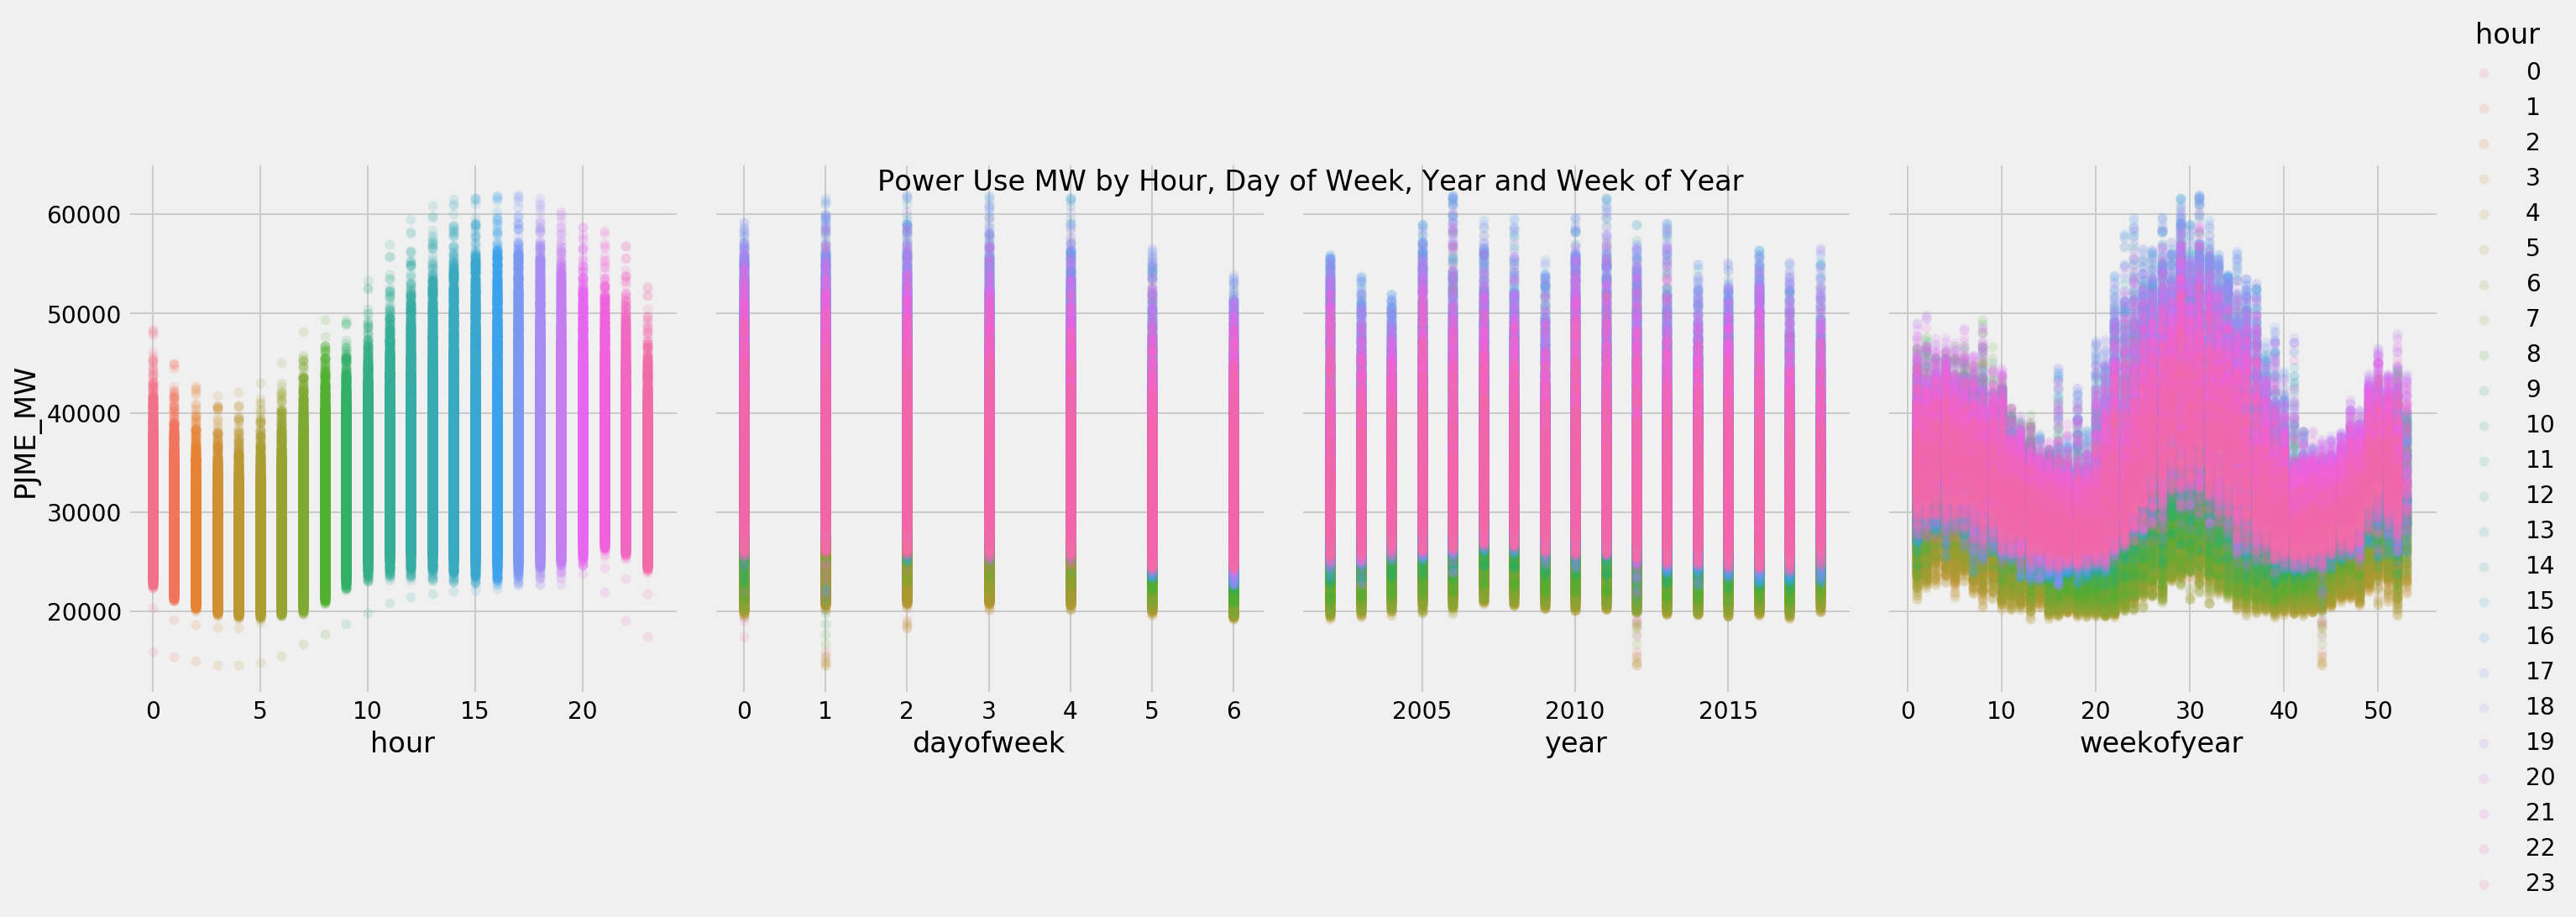

In [33]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

# 훈련/검증 데이터
- 2015년 이후를 검증 데이터로

In [34]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

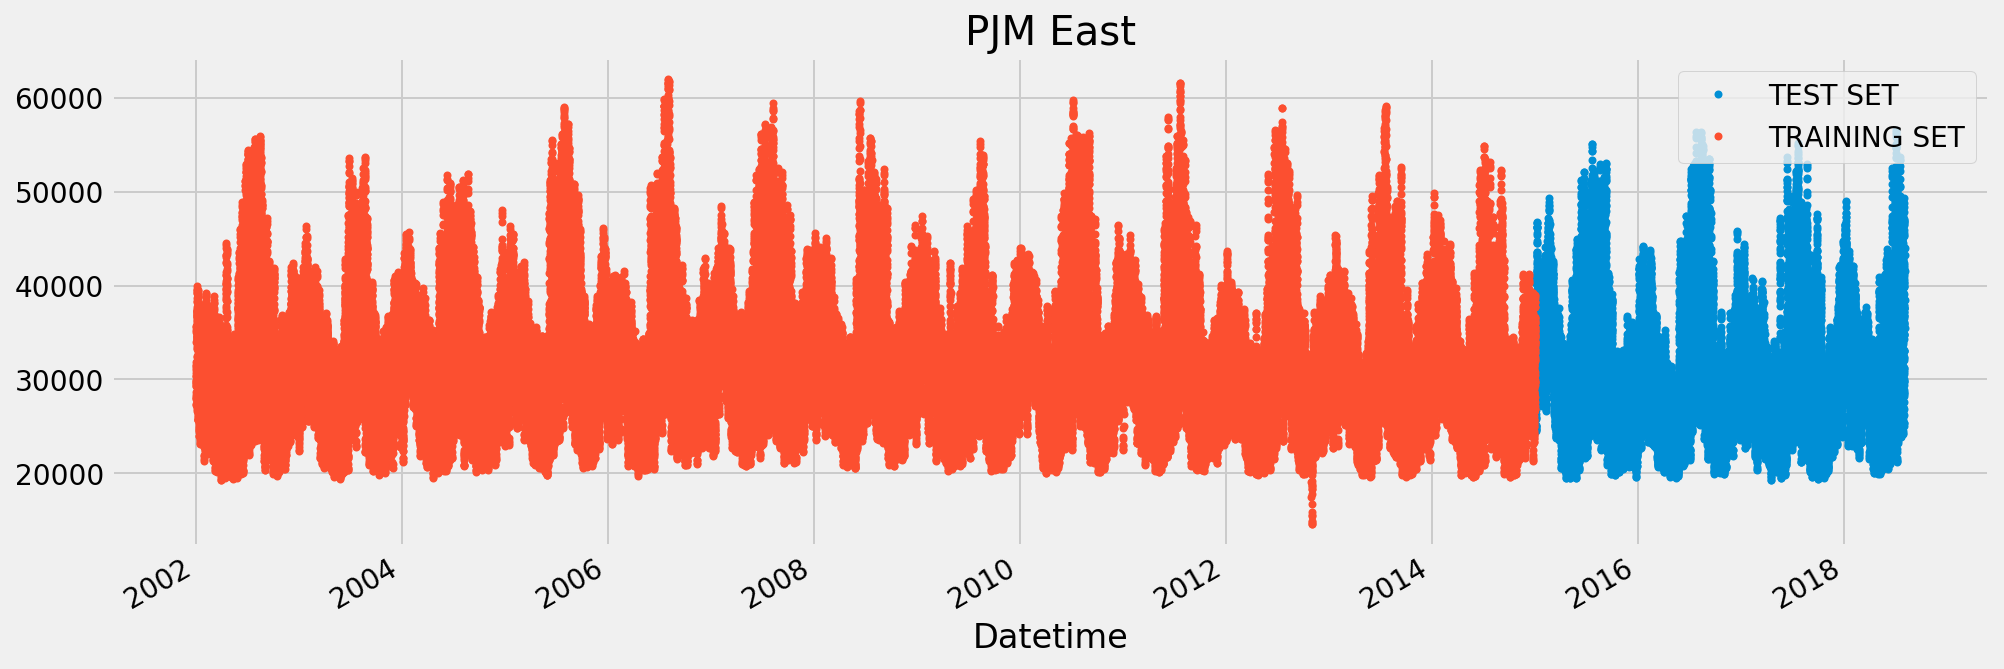

In [37]:
# 데이터 이름을 다르게 그린다
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

In [42]:
pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'})[:3]

TRAINING SET
Datetime                         
2002-12-31 01:00:00       26498.0
2002-12-31 02:00:00       25147.0
2002-12-31 03:00:00       24574.0

In [43]:
pjme_train[:3]

PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0

# 단순 Prophet 모델
- ds, y 컬럼명

In [45]:
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})[:3]

ds        y
0 2002-12-31 01:00:00  26498.0
1 2002-12-31 02:00:00  25147.0
2 2002-12-31 03:00:00  24574.0

In [46]:
# 모델 설정 및 훈련
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [47]:
# 예측
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [48]:
pjme_test_fcst[:2]

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2015-01-01 01:00:00  31207.063831  23707.242004  32988.770579  31207.063831   
1 2015-01-01 02:00:00  31207.026202  22228.568522  31369.106781  31207.026202   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  31207.063831    -2868.419002          -2868.419002          -2868.419002   
1  31207.026202    -4372.817968          -4372.817968          -4372.817968   

         daily  ...       weekly  weekly_lower  weekly_upper      yearly  \
0 -4430.402129  ...  1281.405218   1281.405218   1281.405218  280.577909   
1 -5927.333427  ...  1272.645796   1272.645796   1272.645796  281.869663   

   yearly_lower  yearly_upper  multiplicative_terms  \
0    280.577909    280.577909                   0.0   
1    281.869663    281.869663                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  28338.644829  
1                         0.0                         0.0  26834.208234  

[2 rows x 22 columns]

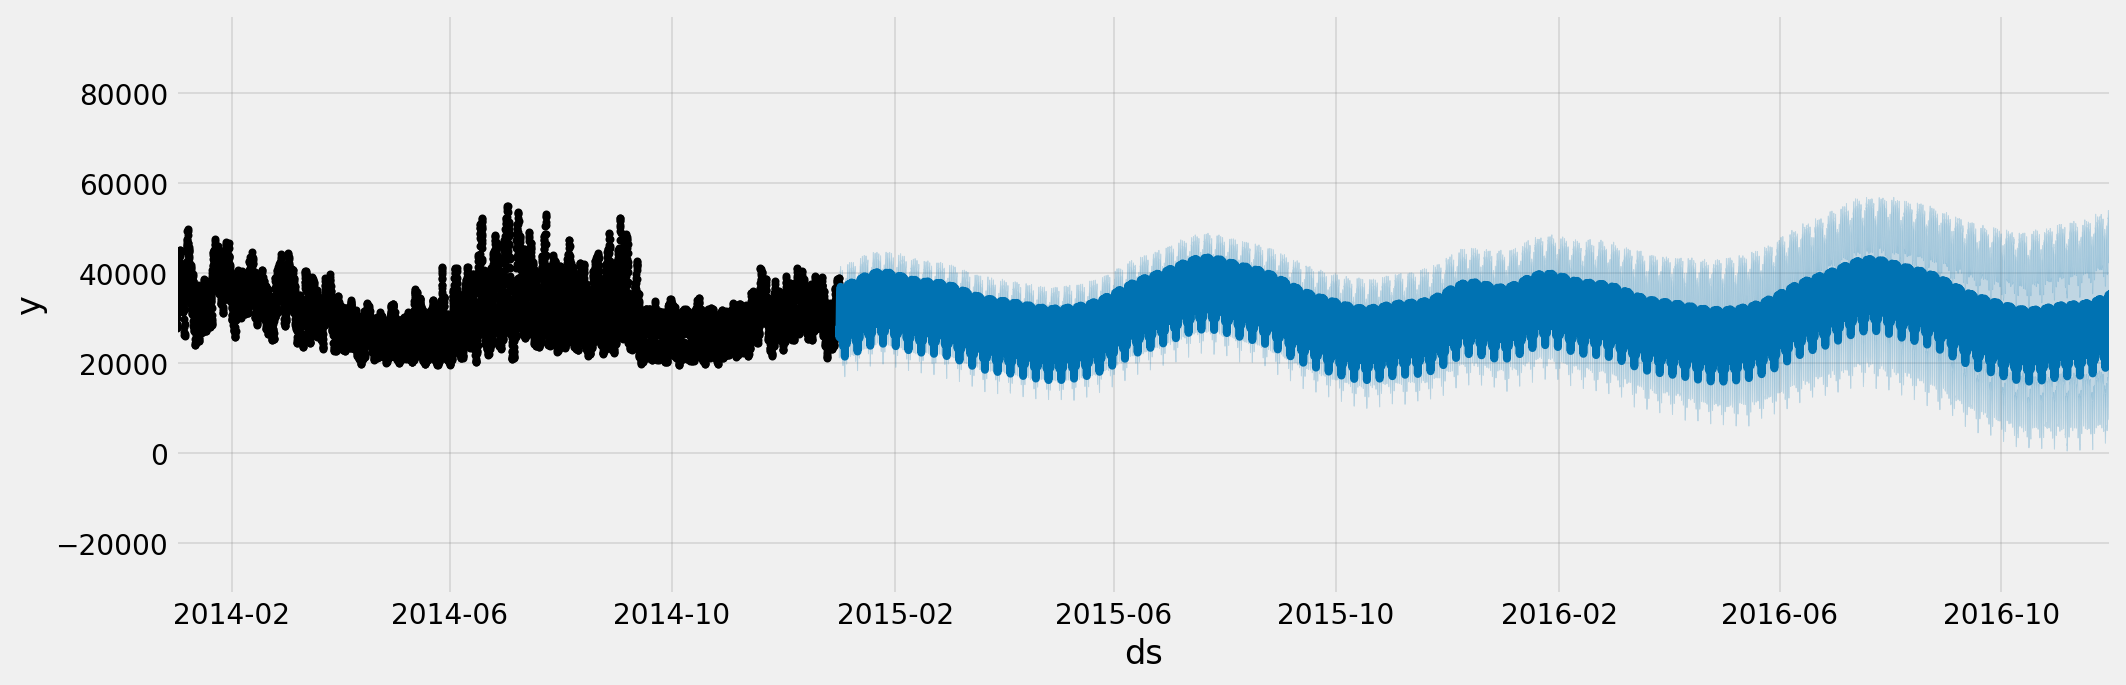

In [56]:
f,ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst, ax=ax)
# ax.set_xlim([datetime(2014, 1, 1), datetime(2016, 12, 1)])
plt.xlim([datetime(2014, 1, 1), datetime(2016, 12, 1)])
# plt.xlim([datetime(2014, 1, 1), pjme_test_fcst.ds.max()])
plt.show()

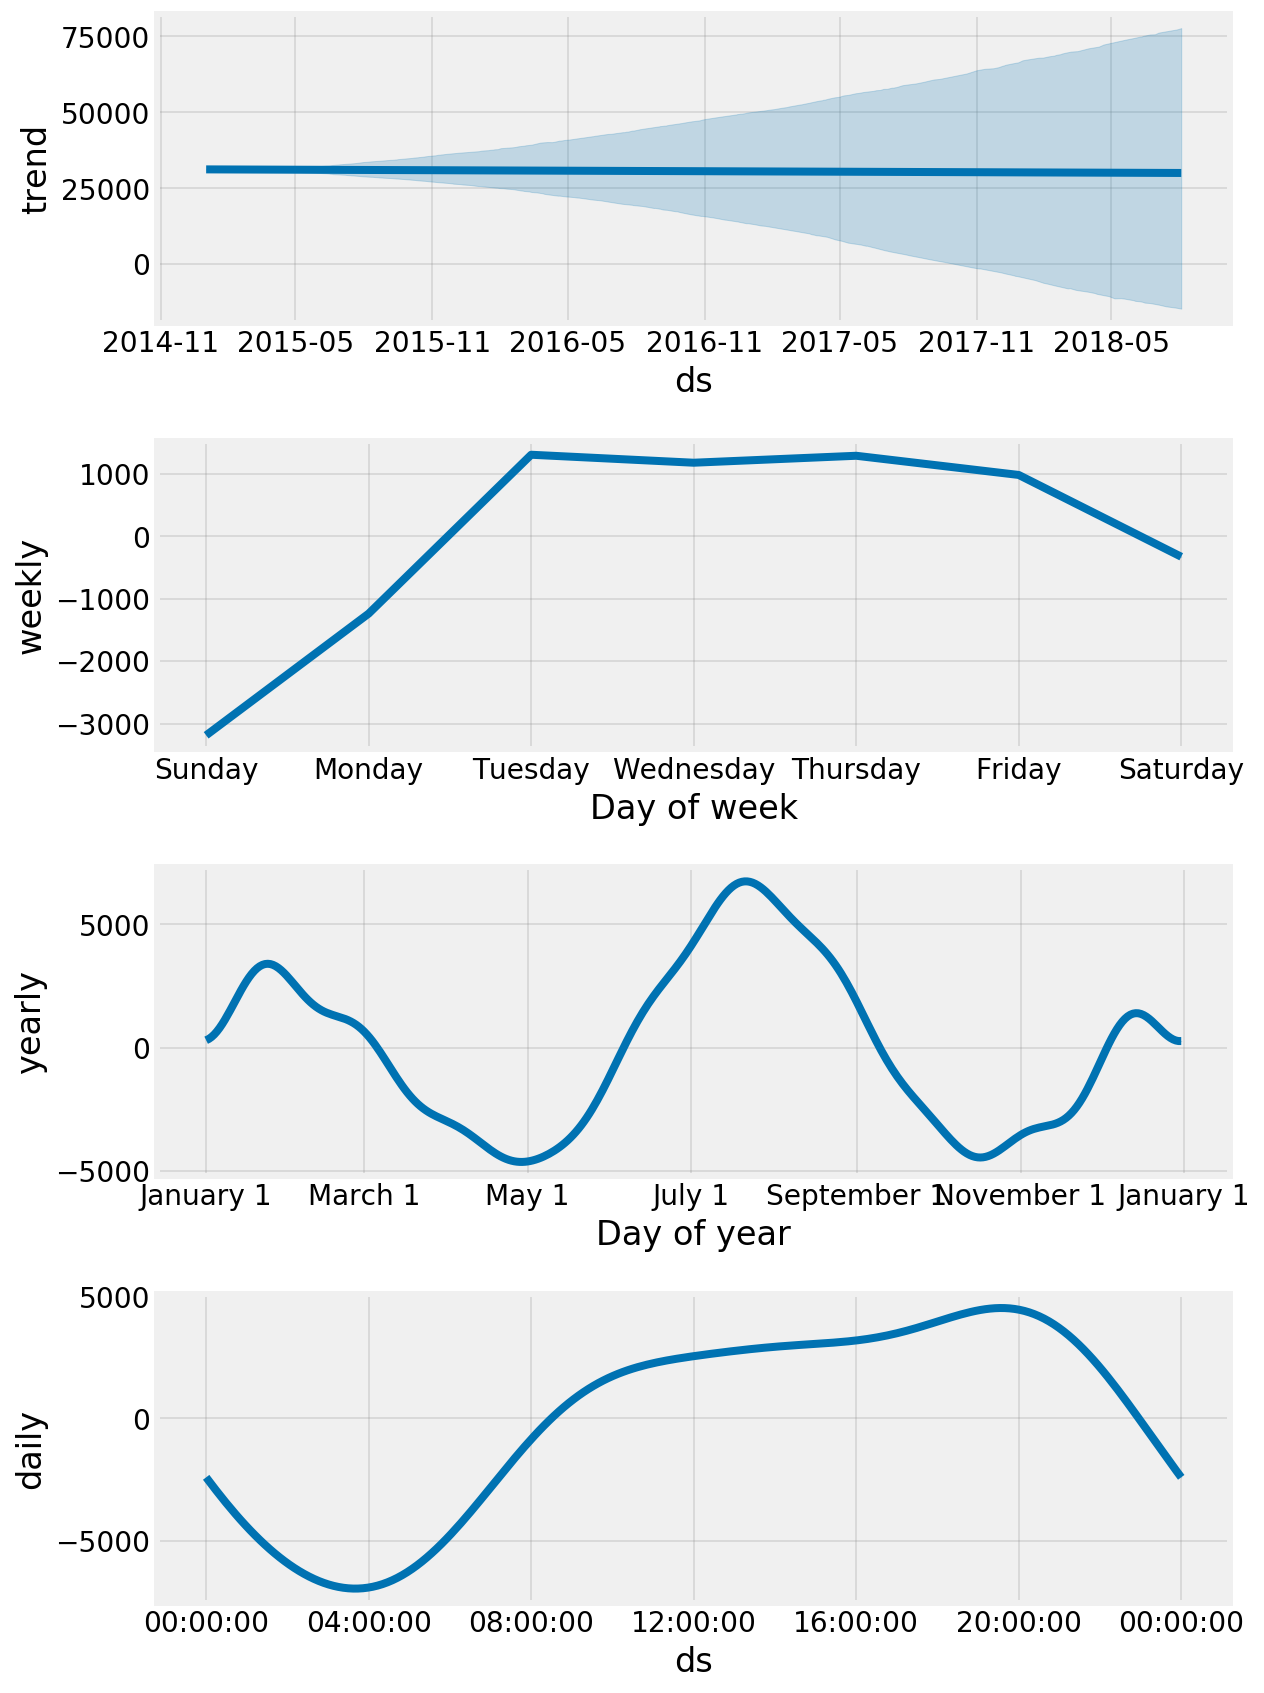

In [57]:
# 콤포넌트
fig = model.plot_components(pjme_test_fcst)

# 실제 값과 비교

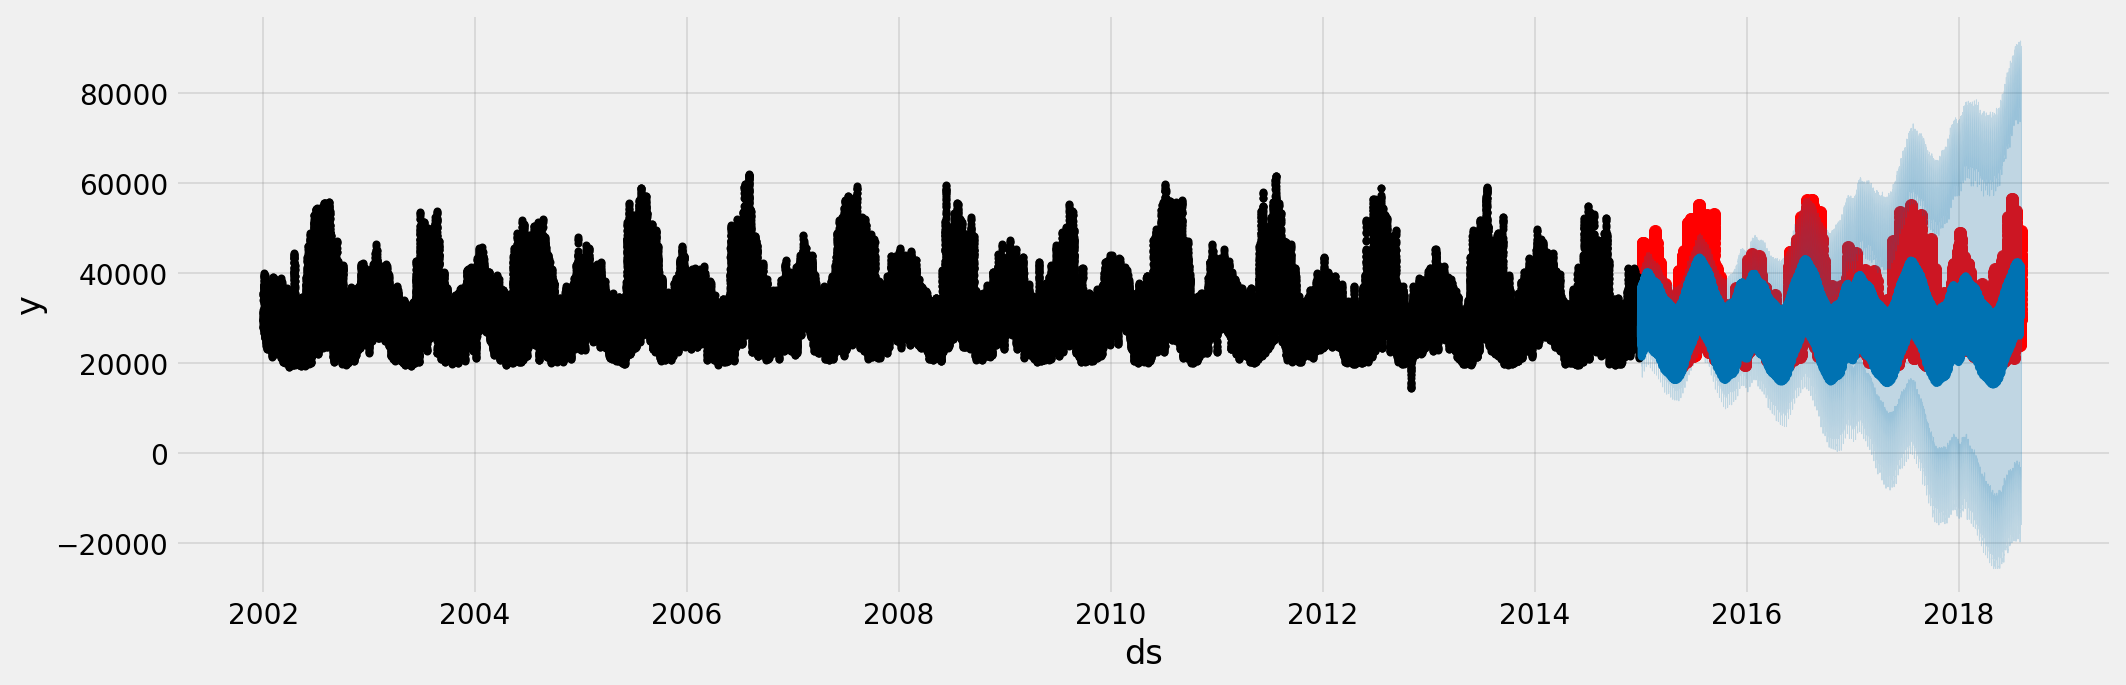

In [62]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
# plt.xlim([datetime(2014, 7, 1), datetime(2015, 7, 1)])

## 예측 1개월 보기

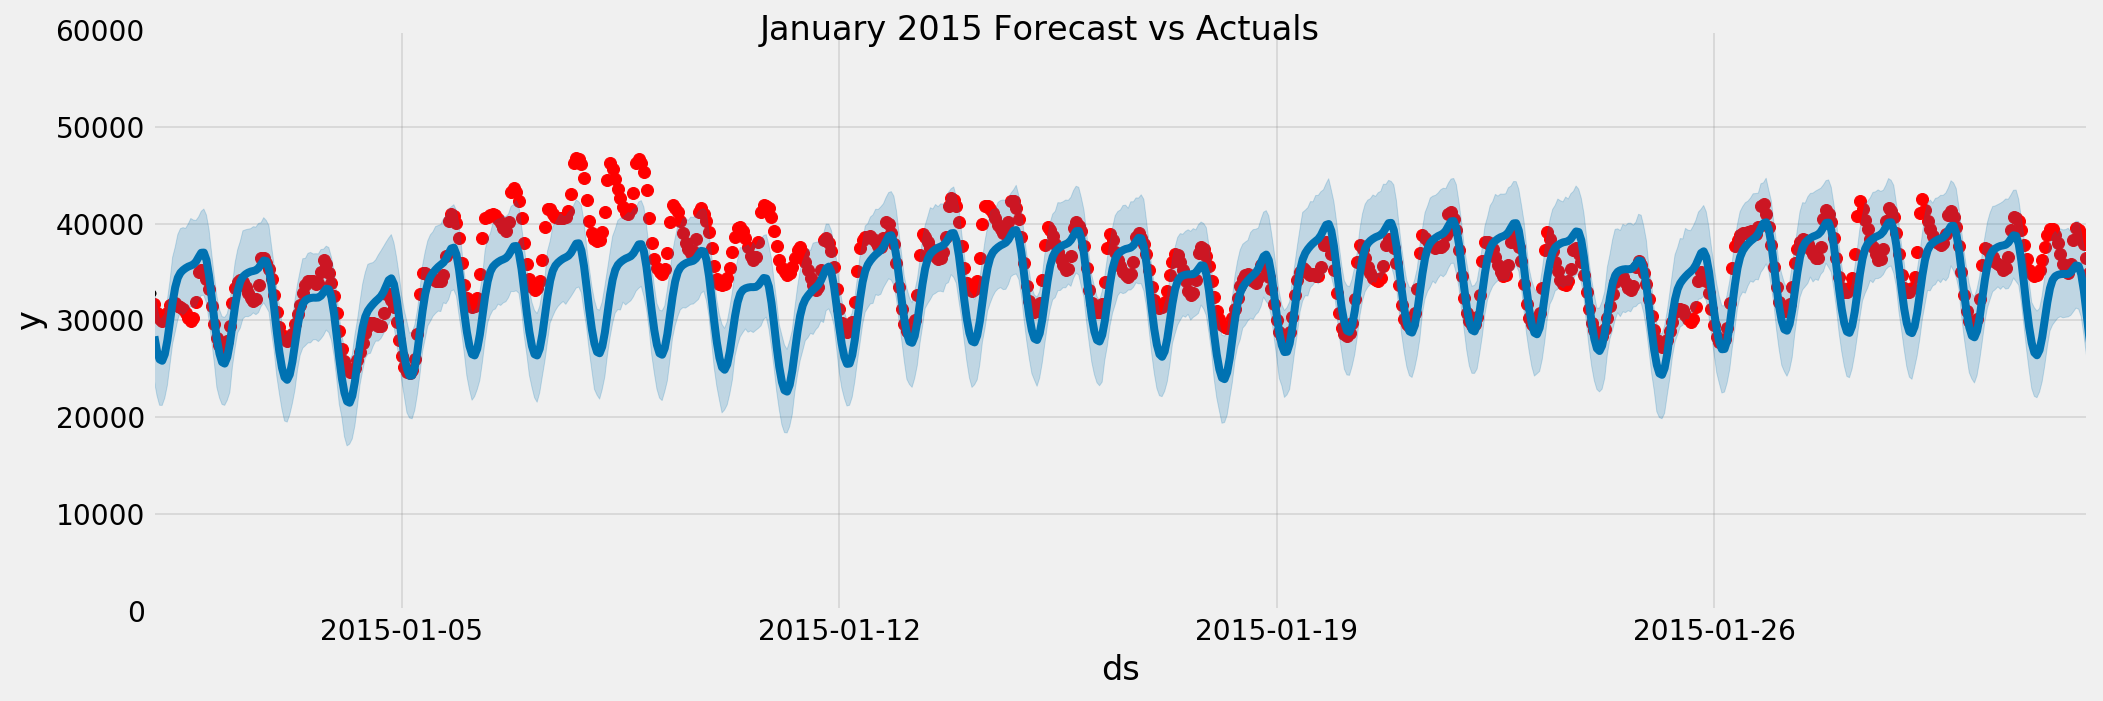

In [64]:
from datetime import datetime
f, ax = plt.subplots(1, figsize=(15,5))
# f.set_figheight(5)
# f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim([datetime(2015, 1, 1), datetime(2015, 2, 1)])
# 다른 방법
# ax.set_xlim([pd.to_datetime('2015, 1, 1'), 
#              pd.to_datetime('2015, 2, 1')])
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

# 1주일 예측

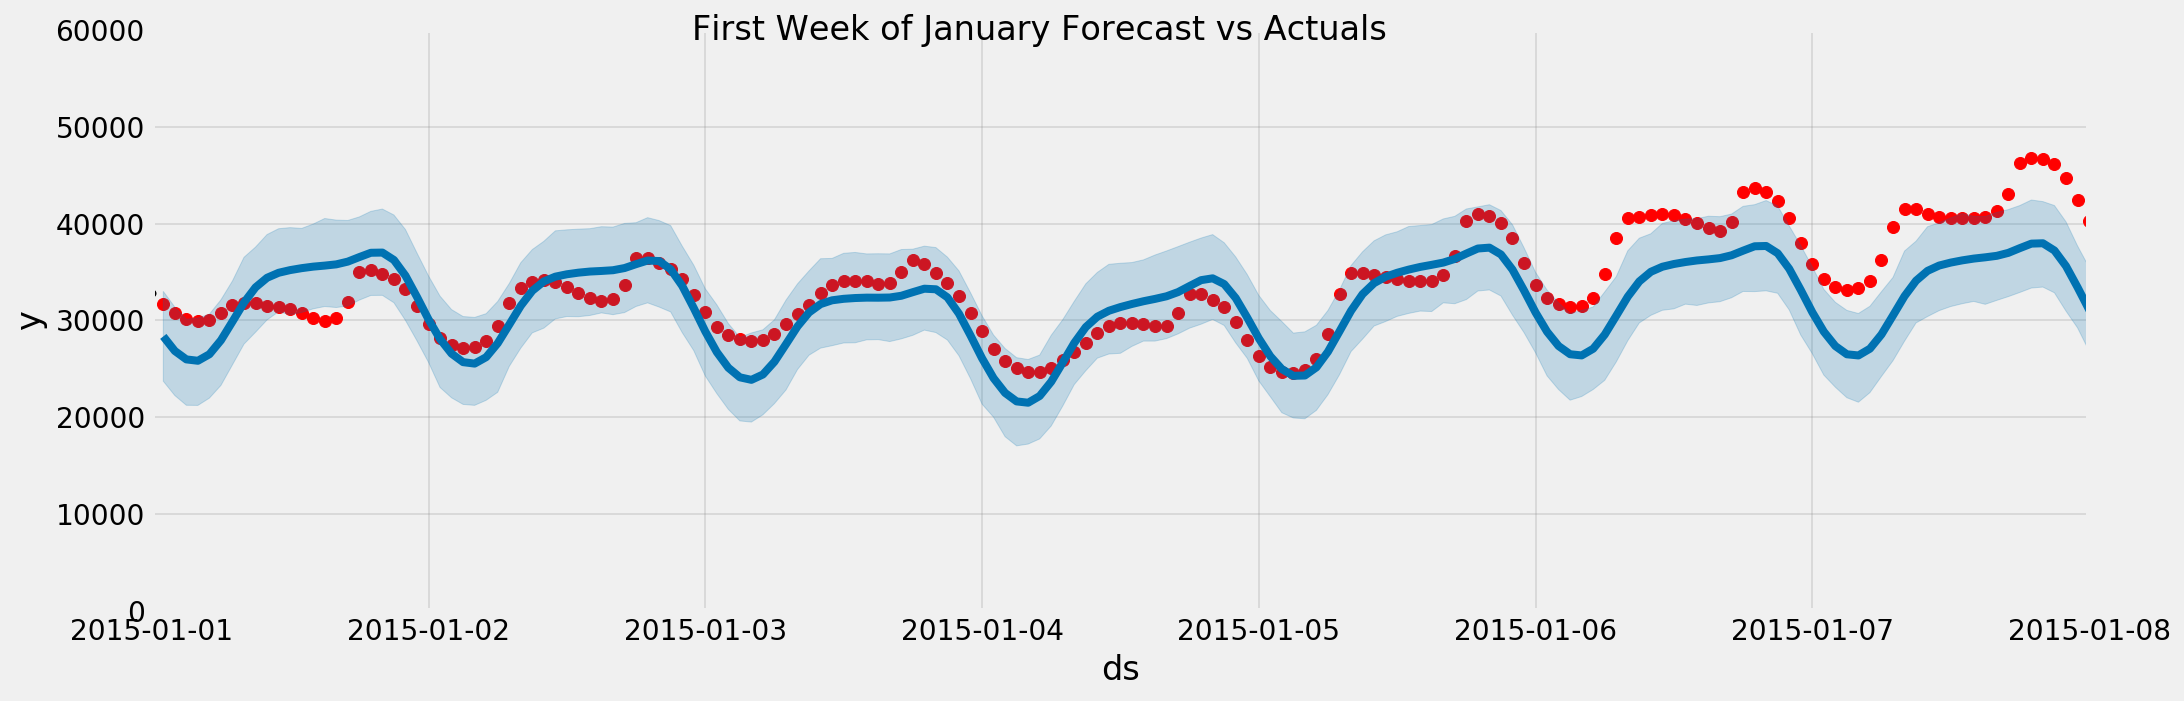

In [65]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1, figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim([datetime(2015, 1, 1), datetime(2015, 1, 8)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

# 성능 평가
- XGBoost 모델 비교[Check that out here](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-xgboost/)

In [74]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

43792398.44939587

In [75]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5182.773042911244

In [76]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.510175822754576

# 휴일 추가
- `USFederalHolidayCalendar`를 추가해보겠다

In [77]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

In [78]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

ds           holiday
0 2003-01-01 00:00:00  USFederalHoliday
1 2002-12-25 01:00:00  USFederalHoliday
2 2002-12-25 02:00:00  USFederalHoliday
3 2002-12-25 03:00:00  USFederalHoliday
4 2002-12-25 04:00:00  USFederalHoliday

In [79]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [80]:
# 휴일 정보 추가
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'PJME_MW':'y'}))

In [81]:
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

## 휴일 효과 보기

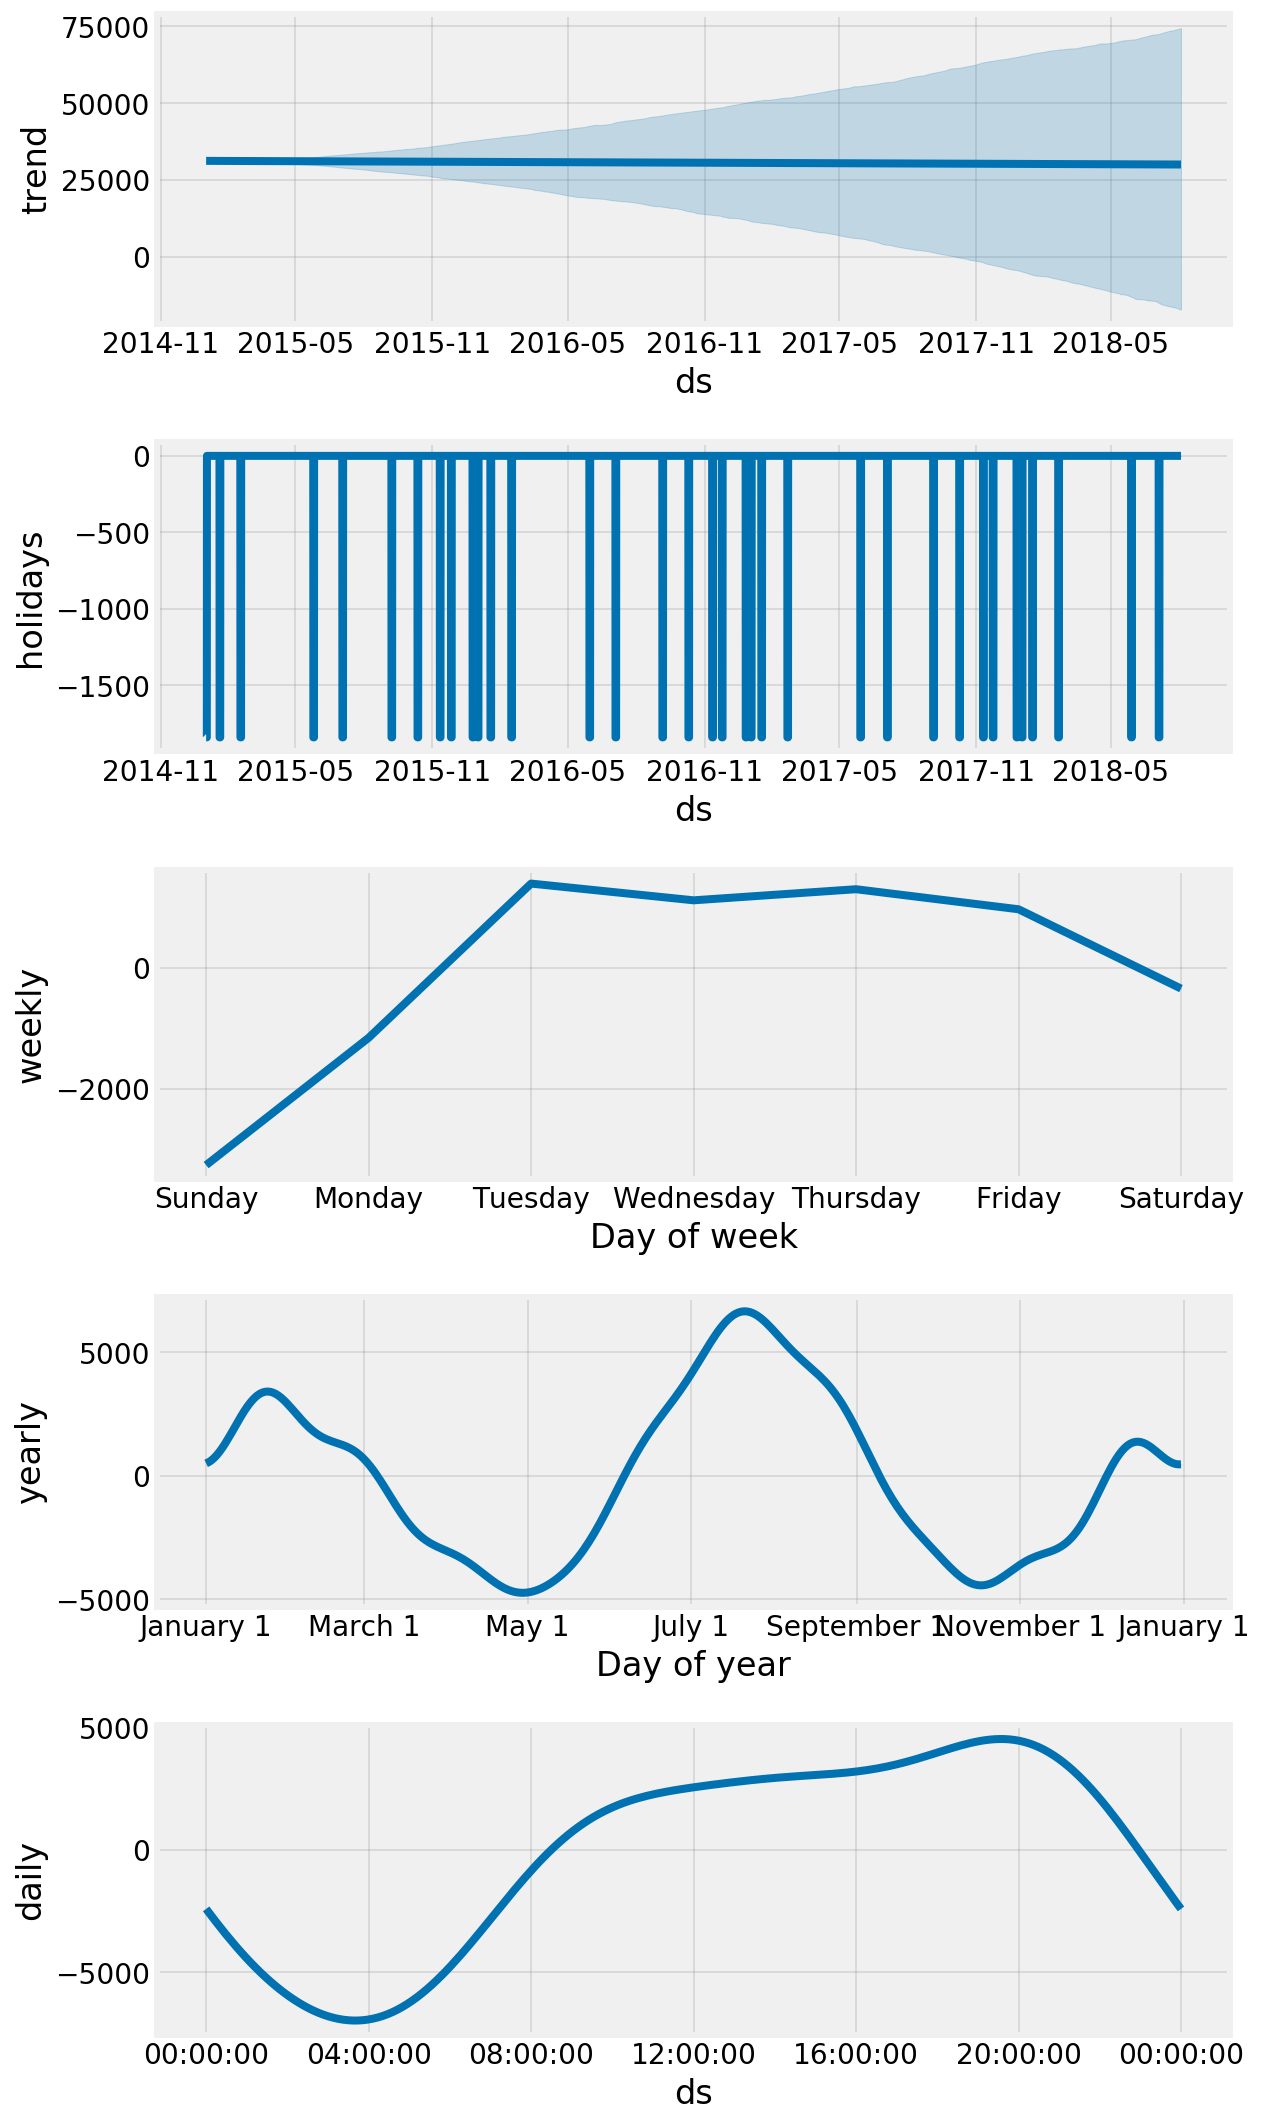

In [82]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

## 성능 비교
- 성능이 개선되지 않았다

In [85]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

43893410.154812604

In [86]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5190.958091846698

In [87]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.539091974772564

## 모델 성능 비교
- 7월 4일을 포함한 경우와 아닌 경우의 성능 비교

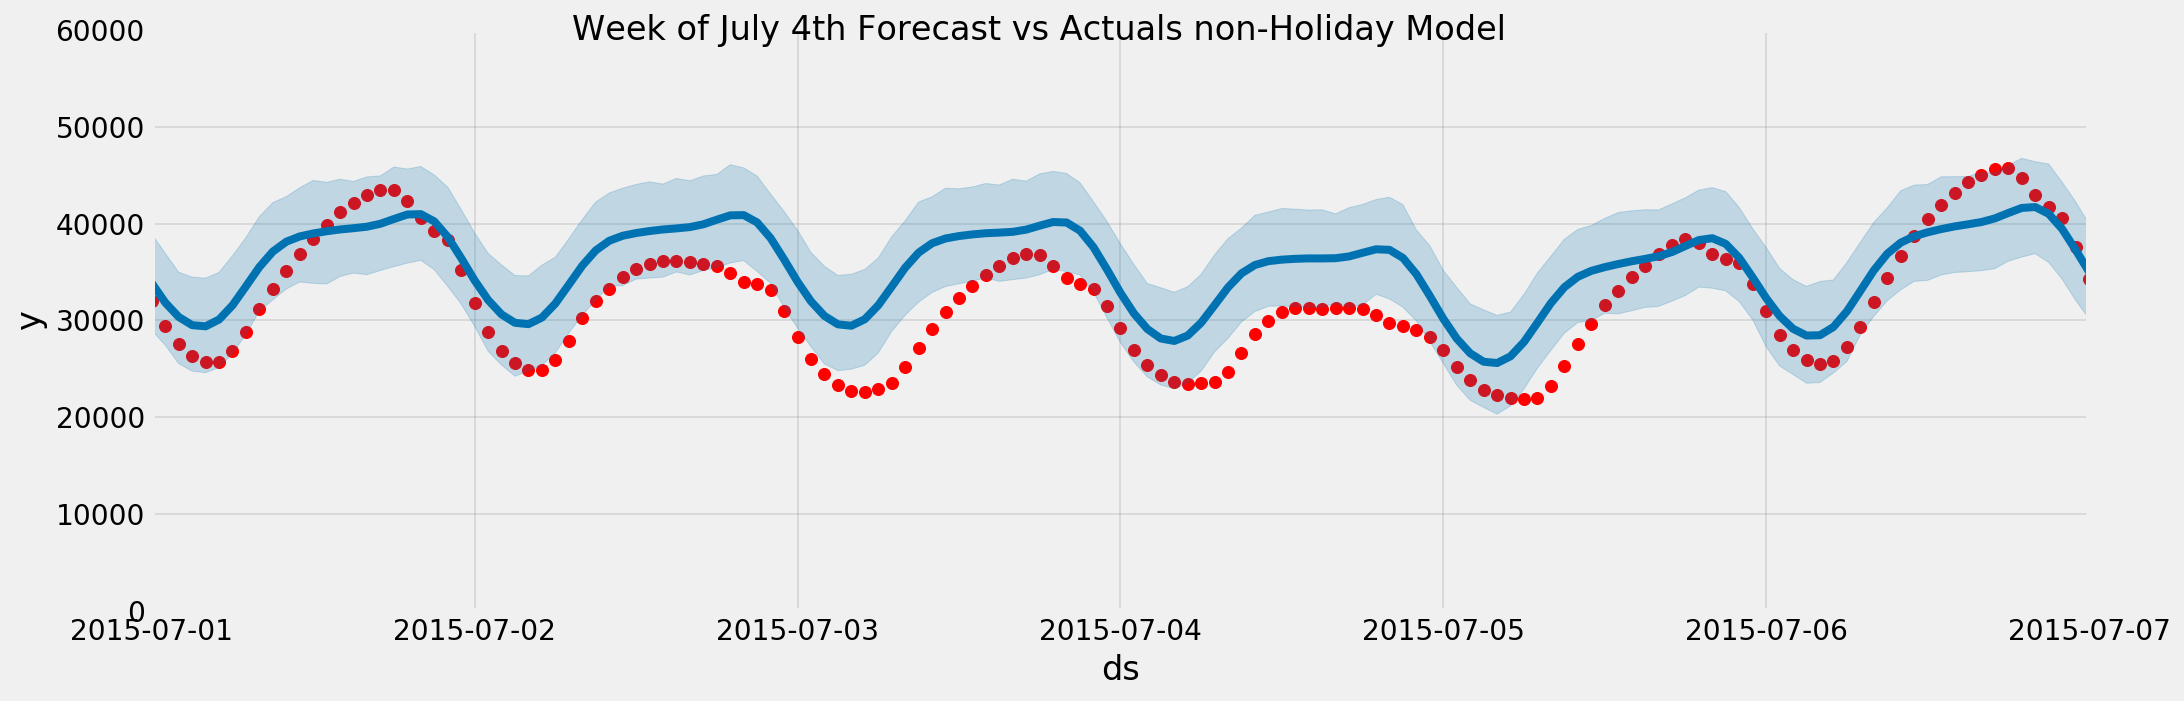

In [88]:
f, ax = plt.subplots(1, figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
plt.xlim([datetime(2015, 7, 1), datetime(2015, 7, 7)])
plt.ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

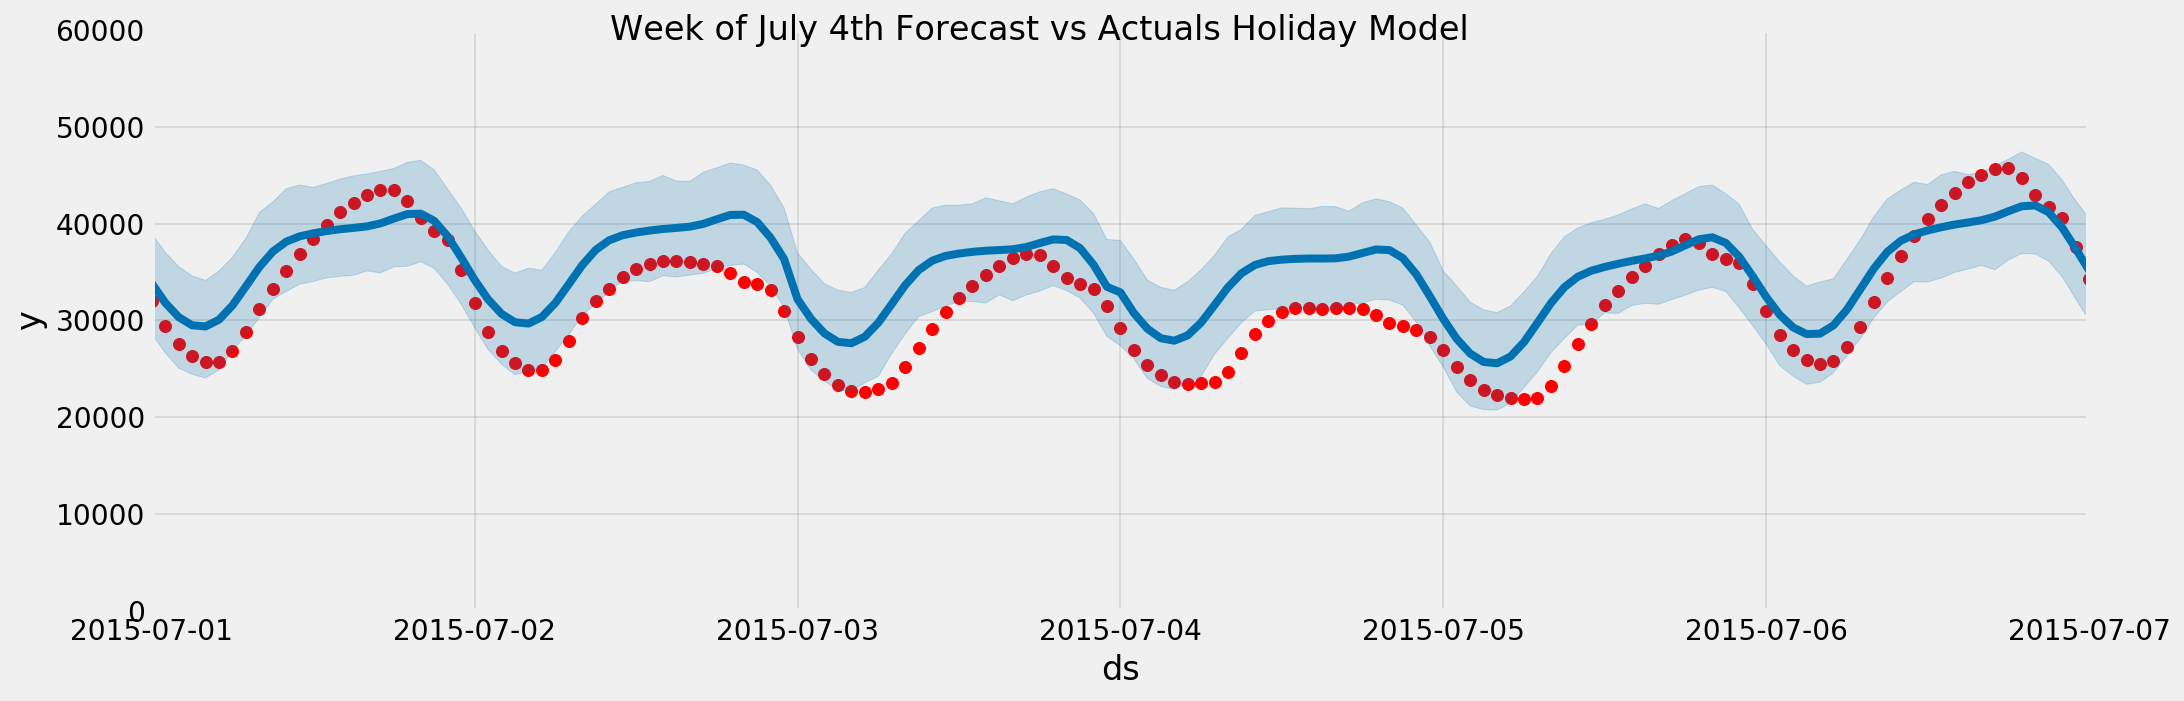

In [89]:
# 휴일을 고려한 경우
f, ax = plt.subplots(1, figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')

fig = model.plot(pjme_test_fcst_with_hols, ax=ax)

plt.xlim([datetime(2015, 7, 1), datetime(2015, 7, 7)])
plt.ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

## 4th of July 고려


In [96]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [93]:
# jul4_test = pjme_test.query('Datetime >= 20160704 and Datetime < 20160706')
# jul4_pred = pjme_test_fcst.query('ds >= 20160704 and ds < 20160706')
# jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160704 and ds < 20160706')

In [97]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred['yhat'])

2157.522319729113

In [98]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred_holiday_model['yhat'])

2157.524583131448

# 휴일 오류
- 개선되지 않았다

In [103]:
holiday_list = holiday_df['ds'].tolist()

In [104]:
hols_test = pjme_test.query('Datetime in @holiday_list')
hols_pred = pjme_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')

In [105]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])

5223.991673196118

In [106]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred_holiday_model['yhat'])

5126.063500569167

## 휴일의 종류를 구분

In [107]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 01, 2015:    
 MAE (non-holiday model): 3086.5 
 MAE (Holiday Model): 2673.8 
 Diff 412.8
Holiday: January 19, 2015:    
 MAE (non-holiday model): 2410.0 
 MAE (Holiday Model): 2088.2 
 Diff 321.8
Holiday: February 16, 2015:    
 MAE (non-holiday model): 11120.9 
 MAE (Holiday Model): 12716.7 
 Diff -1595.8
Holiday: May 25, 2015:    
 MAE (non-holiday model): 1561.3 
 MAE (Holiday Model): 1631.6 
 Diff -70.4
Holiday: July 03, 2015:    
 MAE (non-holiday model): 6049.2 
 MAE (Holiday Model): 4244.4 
 Diff 1804.8
Holiday: September 07, 2015:    
 MAE (non-holiday model): 3851.8 
 MAE (Holiday Model): 4356.3 
 Diff -504.5
Holiday: October 12, 2015:    
 MAE (non-holiday model): 1582.7 
 MAE (Holiday Model): 1904.2 
 Diff -321.5
Holiday: November 11, 2015:    
 MAE (non-holiday model): 2038.7 
 MAE (Holiday Model): 1586.4 
 Diff 452.3
Holiday: November 26, 2015:    
 MAE (non-holiday model): 4656.3 
 MAE (Holiday Model): 3782.2 
 Diff 874.2
Holiday: December 25, 2015:    


## 각 예측 모델의 오류 출력
- 피크 일자의 오류 증가

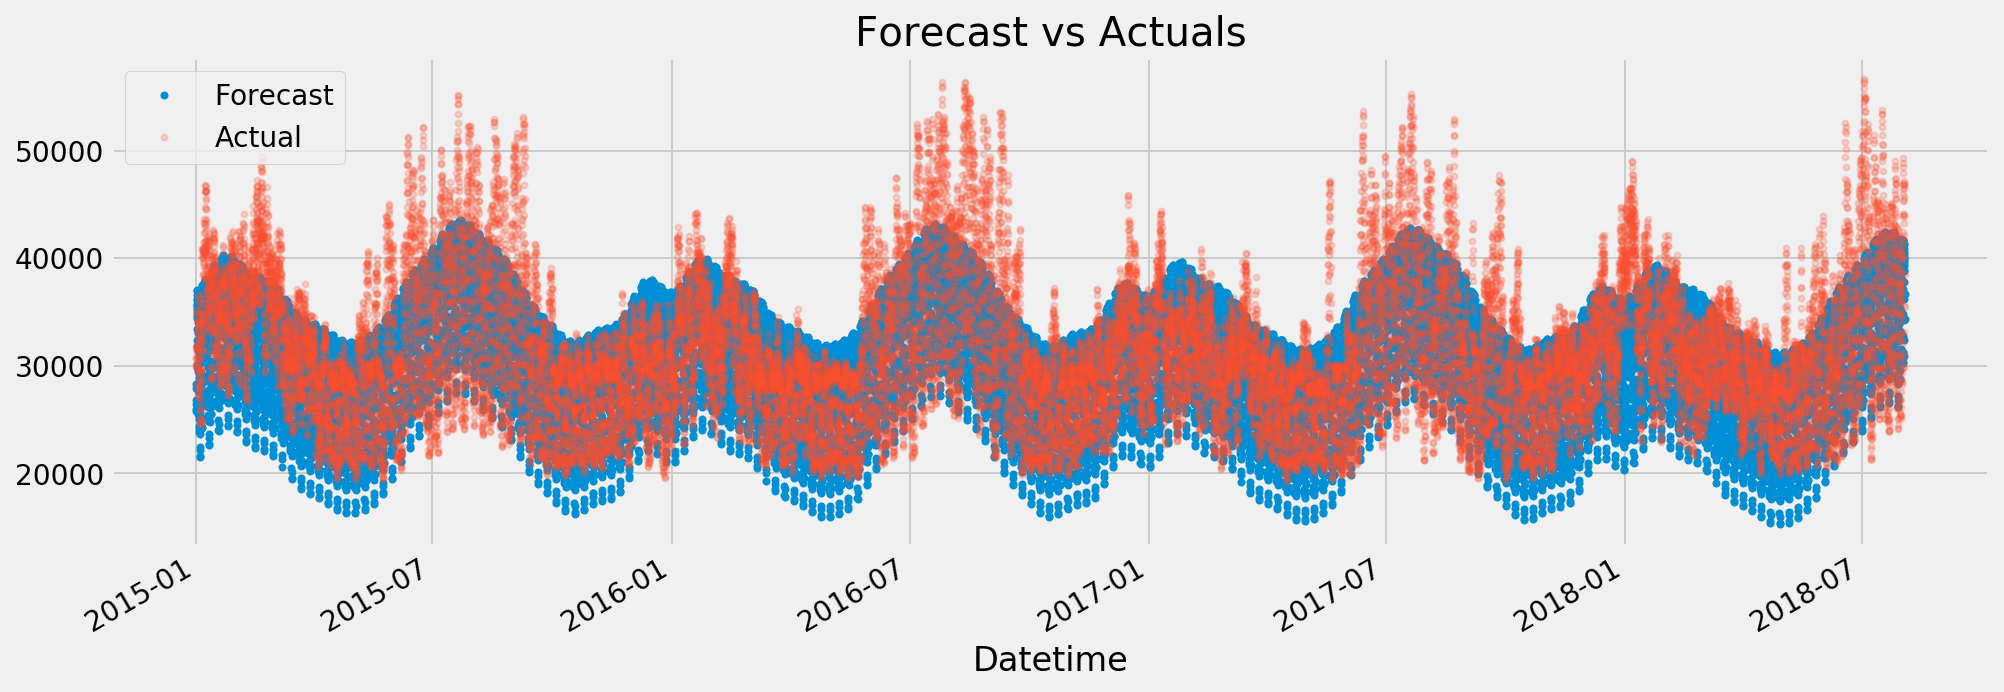

In [108]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
pjme_test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

#  데이터 클리닝
- 이상치는 학습에서 제거해야
- 특별히 전력 사용이 적은 구간 검출

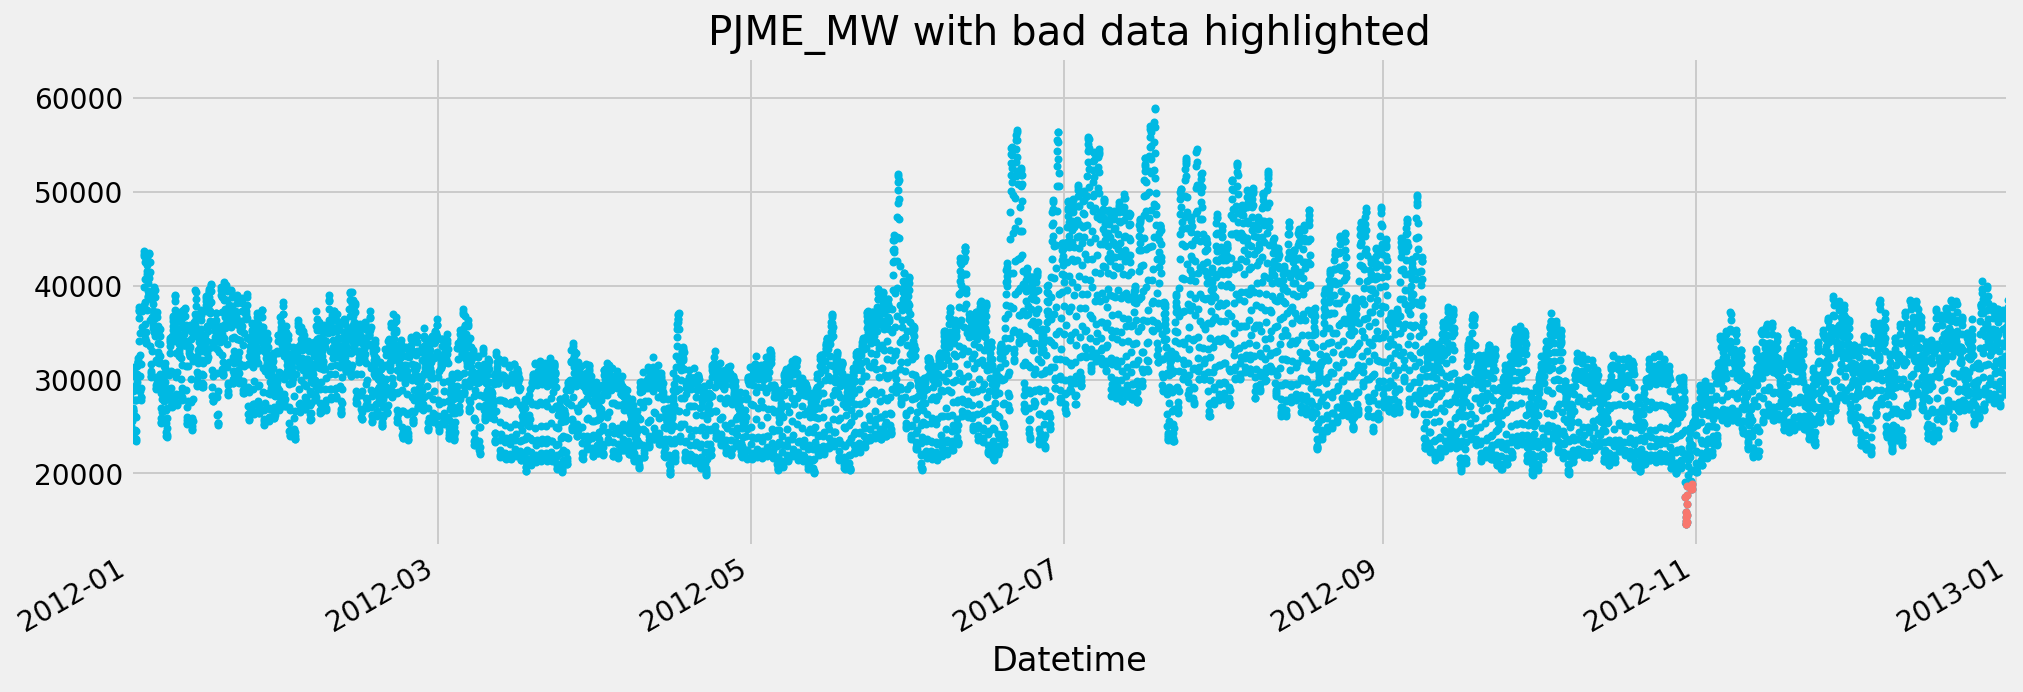

In [109]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

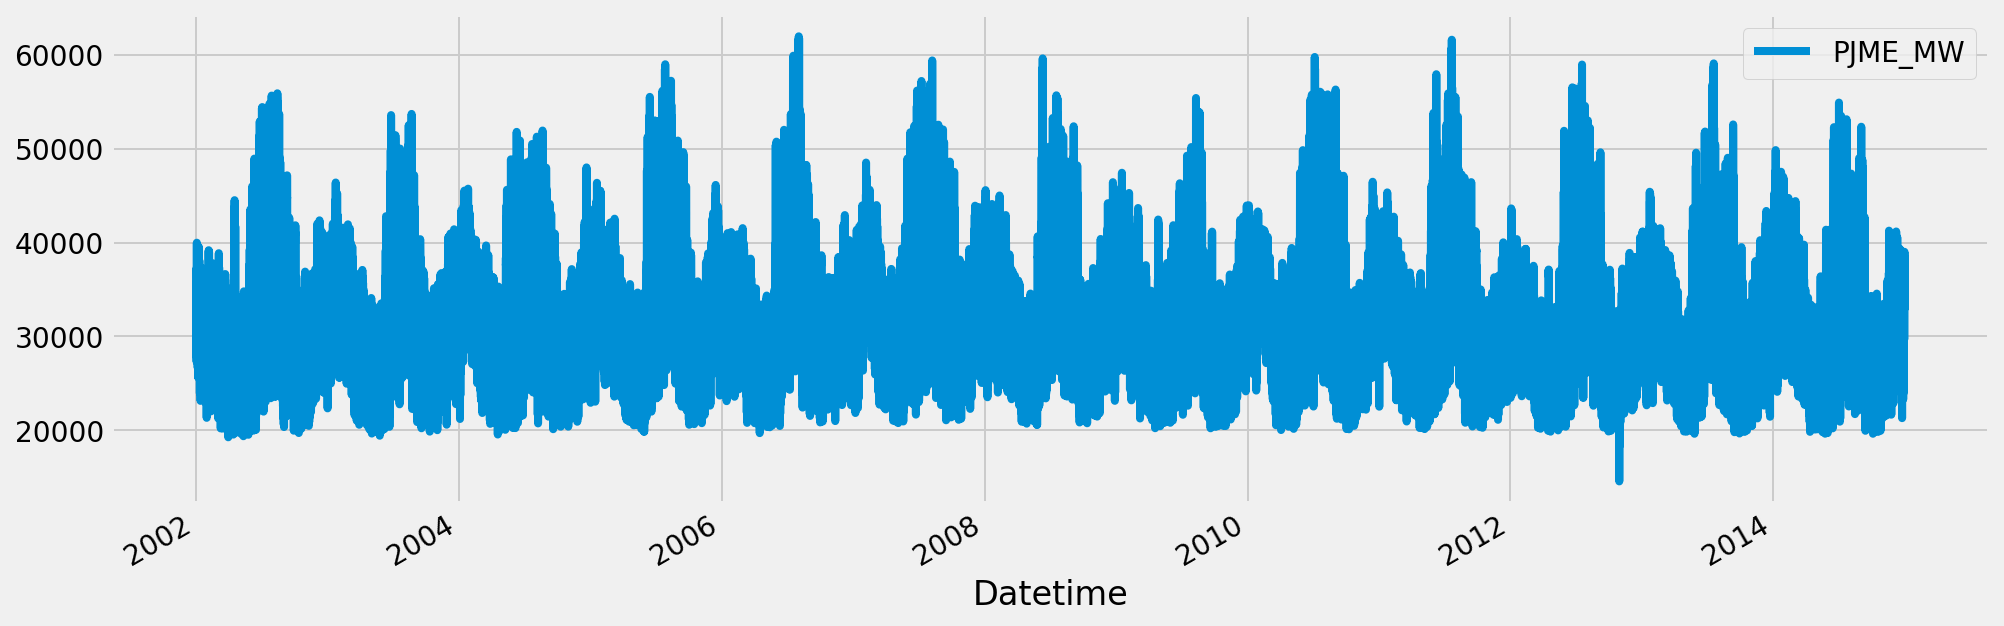

In [110]:
pjme_train.plot(figsize=(15, 5))
plt.show()

- 허리케인으로 전력사용 급감

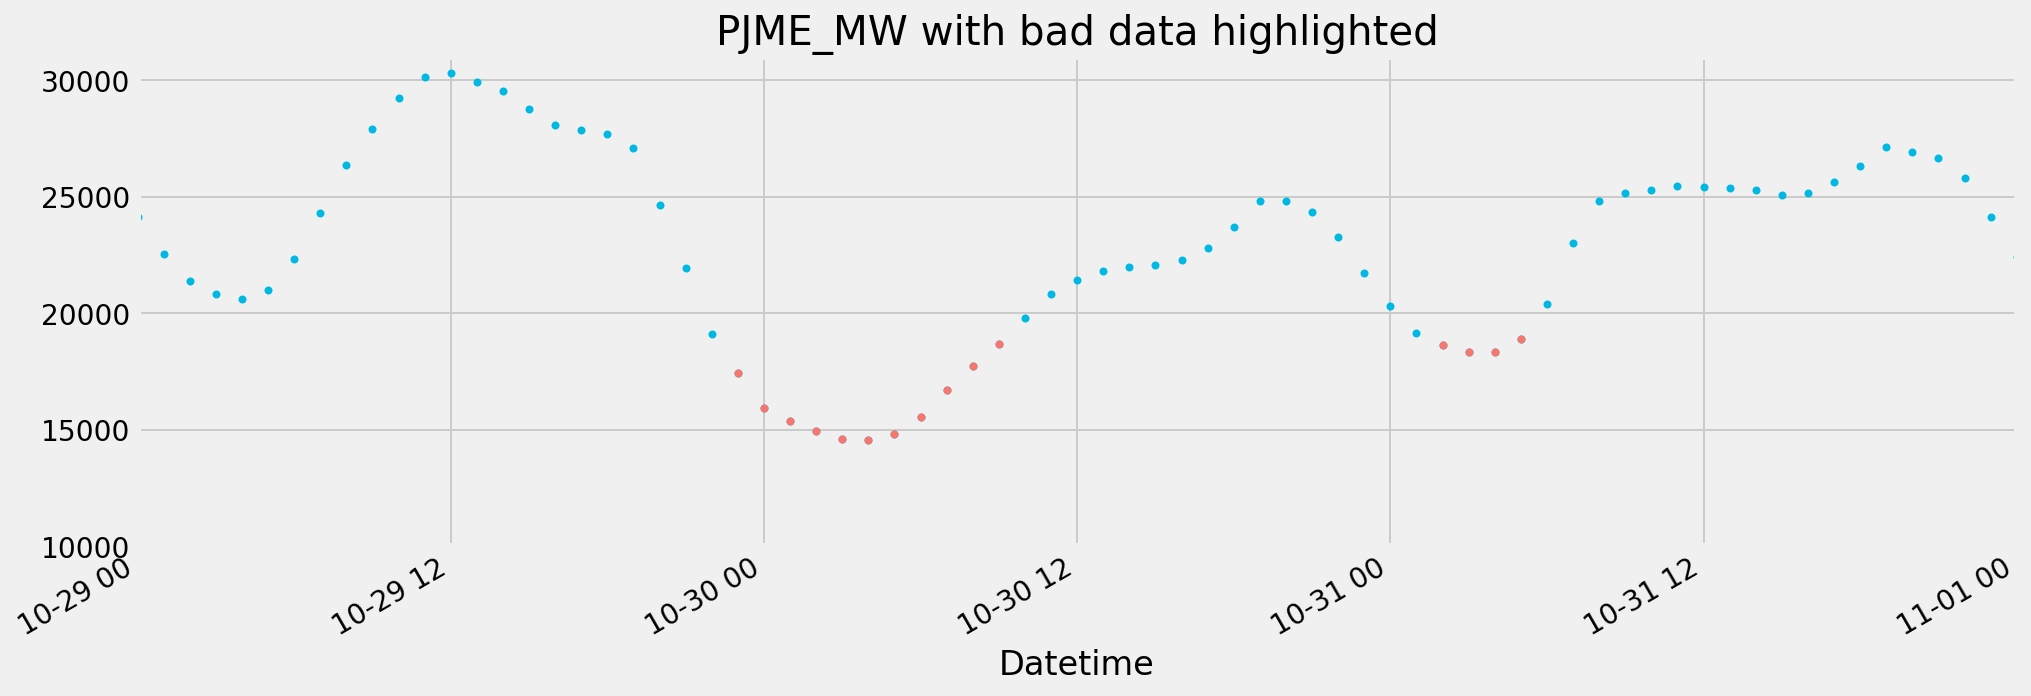

In [111]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('10-29-2012','11-01-2012'),
                     ylim=(10000, 31000)
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

In [112]:
# 데이터 삭제
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

# 재학습
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'})
         )

# 예측
pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

- 데이터 크리닝으로 성능개선
- 이러한 작업을 계속 수행해야 한다

In [113]:
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                y_pred=pjme_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                            y_pred=pjme_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 43770080.4669 - MAE 5181.0088 - MAPE 16.5111


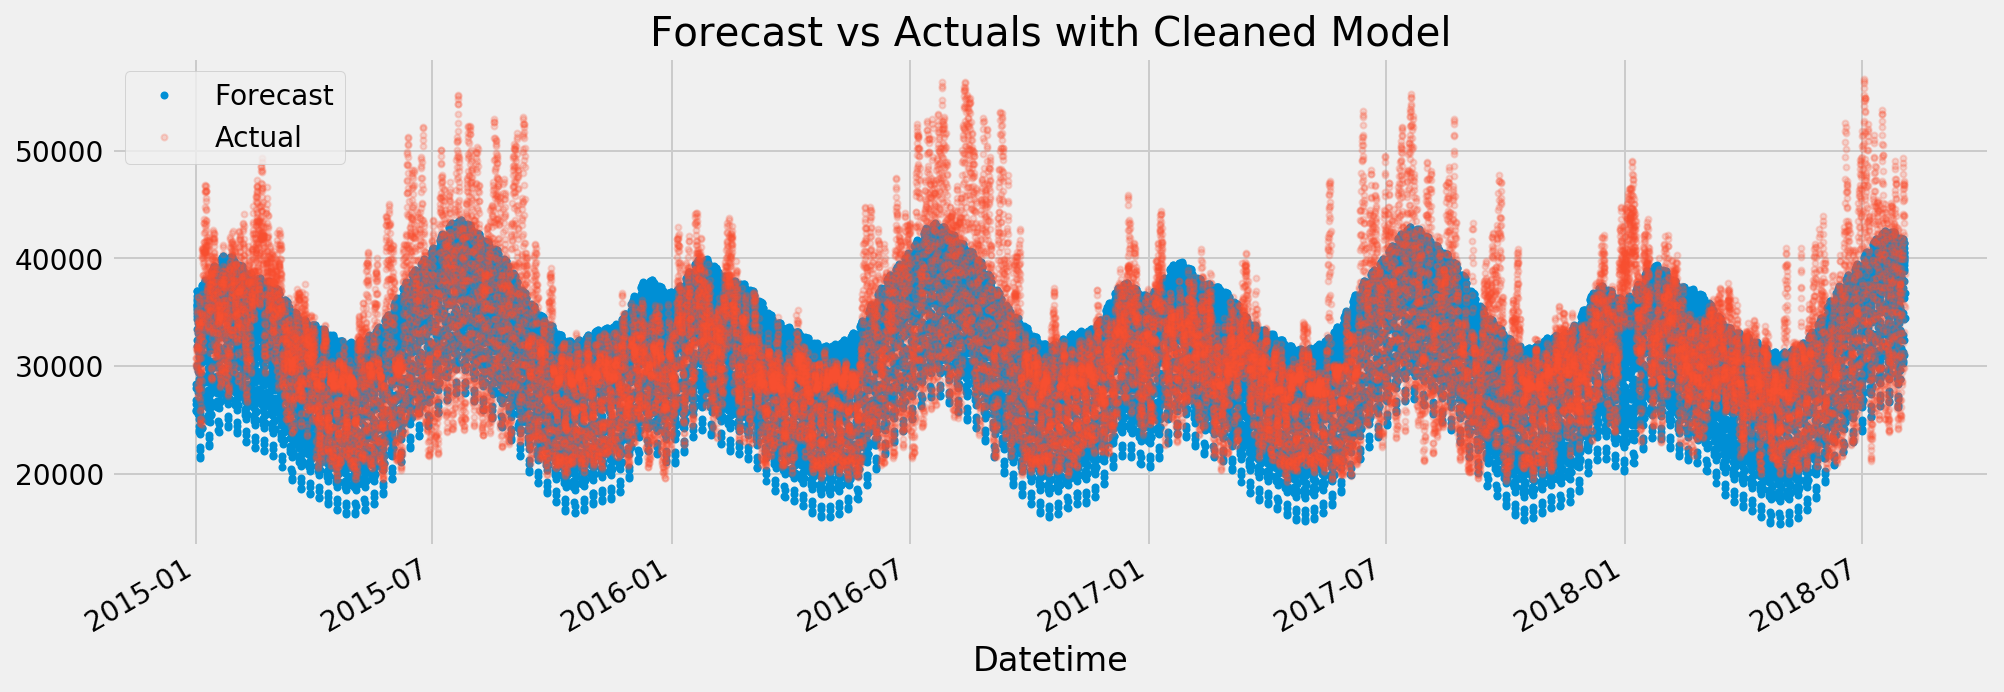

In [114]:
ax = pjme_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()